# Practical Activity 2 (**PRA2**)

<div class="alert alert-block alert-info">
<strong>Name and surname:</strong> Maria Pilligua (NIU: 1638307)
</div>

## Introduction

[Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment is part of the [Box2D](https://gymnasium.farama.org/environments/box2d/) environments. Lunar Lander is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two versions of the environment: discrete and continuous. The landing pad is always at the coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

<img src="https://gymnasium.farama.org/_images/lunar_lander.gif" width="400px" />

More information can be found at:
- [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

In order to initialize the environment, we will use the discrete action space `continuous=False`, as depicted in the following code:

In [2]:
import gymnasium as gym
import torch

In [3]:
env = gym.make("LunarLander-v2", continuous=False)

print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))
print("Reward range is {} ".format(env.reward_range))

Action space is Discrete(4) 
Observation space is Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32) 
Reward range is (-inf, inf) 


In [4]:
import cv2
import numpy as np
import collections

class TruncatedEnv(gym.Wrapper):
    """
    A wrapper for truncating episodes after a fixed number of steps.
    """
    def __init__(self, env, max_steps):
        super().__init__(env)
        self.max_steps = max_steps
        self.current_step = 0

    def reset(self, **kwargs):
        self.current_step = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        self.current_step += 1
        obs, reward, truncated, terminated, info = self.env.step(action)
        if self.current_step >= self.max_steps:
            truncated = True
            info['TimeLimit.truncated'] = True 
        return obs, reward, truncated, terminated, info


def make_env(MAX_STEPS_PER_EPISODE):
    # Create a new environment using the truncated environment wrapper
     
    env = gym.make('LunarLander-v2', continuous=False, render_mode="rgb_array")
    env = TruncatedEnv(env, max_steps=MAX_STEPS_PER_EPISODE)
    env.reset()
    
    return env


def print_env_info(name, env):
    # Print information about the environment

    obs, _ = env.reset()
    print("*** {} Environment ***".format(name))
    print("Observation sample:/n{}".format(obs))
    print("Observation shape: {}, type: {} and range [{},{}]".format(obs.shape, obs.dtype, np.min(obs), np.max(obs)))

In [5]:
import torch
import torch.nn as nn        
import torch.optim as optim 

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device: {}".format(device))

Using device: cuda


In [3]:
import os
from PIL import Image, ImageSequence
from IPython.display import display, HTML

def merge_gifs(folder_path, output_path):
    """
    Merges all GIFs in the specified folder, trimming each to at most 100 frames,
    and displays the result as an animated GIF.
    """
    # Get all files in the folder
    files = [f for f in os.listdir(folder_path) if f.endswith('.gif')]

    # Sort files: numerical order, but move '000last' to the end
    files.sort(key=lambda x: (x == '000last.gif', x))
    
    # Extract frames from each GIF
    frames = []
    for id, gif_file in enumerate(files):
        gif_path = os.path.join(folder_path, gif_file)
        gif_image = Image.open(gif_path)
        
        # Collect up to 100 frames from the current GIF
        max_frames = 100 if id != len(files) - 1 else 1000
        gif_frames = [frame.copy() for i, frame in enumerate(ImageSequence.Iterator(gif_image)) if i < max_frames]
        frames.extend(gif_frames)
    
    # Save the merged GIF
    frames[0].save(
        output_path, save_all=True, append_images=frames[1:], loop=0, duration=frames[0].info.get('duration', 100)
    )

## Part 1. Deep Q-Networks

### Baseline DQN

We define all components needed for the Baseline DQN training.

In [6]:
import collections

# Define a named tuple for storing transitions (state, action, reward, done flag, and next state).
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceReplay:
    """
    A replay buffer for storing and sampling experiences.
    """

    def __init__(self, capacity):
        # Initialize a fixed-size buffer using deque.
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        # Return the current size of the buffer.
        return len(self.buffer)

    def append(self, experience):
        # Add a new experience to the buffer.
        self.buffer.append(experience)

    def sample(self, BATCH_SIZE):
        # Randomly sample a batch of experiences.
        indices = np.random.choice(len(self.buffer), BATCH_SIZE, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return (np.array(states), 
                np.array(actions), 
                np.array(rewards, dtype=np.float32), 
                np.array(dones, dtype=np.uint8), 
                np.array(next_states))


In [7]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions, hidden_size=512):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
from PIL import Image, ImageDraw, ImageFont
import os
import time

def evaluate_dqn(dirr, env, net, device='cpu', epoch=0):
    """
    Evaluate a DQN model and generate a GIF showing the agent's performance.

    Parameters:
    - dirr (str): Path to save the output GIF.
    - env: Environment instance used for evaluation.
    - net: Trained DQN model.
    - device (str): Device to run the evaluation ('cpu' or 'cuda').
    - epoch (int): Current epoch number (used for labeling in the GIF).

    Returns:
    - total_reward (float): Total reward accumulated during the evaluation.
    """

    state, _ = env.reset()
    images = []
    total_reward = 0.0
    
    # Perform evaluation over a maximum of 1000 time steps
    for t in range(1000):
        # Render the environment to get the current frame as an image
        img = env.render()
        
        # Prepare the current state for the model and get Q-values
        state_ = torch.tensor(np.array([state], copy=False)).to(device)
        q_vals = net(state_).data.cpu().numpy()
        action = np.argmax(q_vals)
        
        # Convert the rendered image to a PIL Image for annotation
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil) 
        
        # Add the step number to the upper-left corner of the image
        font = ImageFont.load_default() 
        draw.text((10, 10), f"Step: {t}", fill="white", font=font)
        
        # Add the epoch number centered at the top of the image
        epoch_text = f"Epoch: {epoch}"
        text_bbox = draw.textbbox((0, 0), epoch_text, font=font) 
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        draw.text(((img_pil.width - text_width) // 2, 10), epoch_text, fill="white", font=font)

        # Take a step in the environment using the selected action
        state, reward, terminated, truncated, _ = env.step(action)
        
        # Add the current reward to the top-right corner of the image
        total_reward += reward
        reward_text = f"Reward: {total_reward:.2f}"
        text_bbox = draw.textbbox((0, 0), reward_text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        draw.text((img_pil.width - text_width - 10, 10), reward_text, fill="white", font=font)
        
        images.append(img_pil)

        # Terminate evaluation if the environment is done
        if terminated or truncated:
            break

    # Save all frames as a GIF with a duration of 60ms per frame and infinite loop
    images[0].save(dirr, save_all=True, append_images=images[1:], duration=60, loop=0)

    env.close()
    return total_reward


In [9]:
class Agent:
    def __init__(self, env, exp_replay_buffer):
        """
        Initialize the agent with the environment and experience replay buffer.

        Args:
            env: The environment in which the agent will interact.
            exp_replay_buffer: Buffer to store experience tuples for training.
        """
        self.env = env
        self.exp_replay_buffer = exp_replay_buffer
        self._reset()

    def _reset(self):
        """
        Reset the environment and initialize state and total reward.
        """
        self.current_state, _ = self.env.reset() 
        self.total_reward = 0.0  # Reset the total reward collected in an episode.

    def step(self, net, epsilon=0.0, device="cpu"):
        """
        Perform a single step in the environment using the given Q-network and epsilon-greedy policy.

        Args:
            net: The Q-network used to determine actions.
            epsilon: Probability of choosing a random action (exploration rate).
            device: Device on which the Q-network resides (e.g., 'cpu' or 'cuda').

        Returns:
            done_reward: The total reward accumulated in the episode, or None if not done.
            done: Boolean indicating whether the episode has ended (either terminated or truncated).
        """
        done_reward = None

        # Decide whether to explore or exploit based on epsilon.
        if np.random.random() < epsilon:
            # Exploration: Choose a random action.
            action = self.env.action_space.sample()
        else:
            # Exploitation: Use the Q-network to predict the best action.
            state_ = np.array([self.current_state]) 
            state = torch.tensor(state_).to(device) 
            q_vals = net(state) 
            _, act_ = torch.max(q_vals, dim=1) 
            action = int(act_.item()) 

        # Take the chosen action in the environment.
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        self.total_reward += reward  # Accumulate the reward.

        # Create an experience tuple and store it in the replay buffer.
        exp = Experience(self.current_state, action, reward, terminated or truncated, new_state)
        self.exp_replay_buffer.append(exp)

        # Update the current state to the new state.
        self.current_state = new_state

        # If the episode has ended, reset the environment and return the total reward.
        if terminated or truncated:
            done_reward = self.total_reward 
            self._reset() 

        return done_reward, terminated or truncated  # Return the total reward and done status.


In [17]:
import wandb
import optuna

os.environ["WANDB_SILENT"] = "true"

def run_dqn(hyperparameters, trial, dueling_dqn=False, double_dqn=False):
    """
    Run DQN training with the given hyperparameters. 

    hyperparameters: dict
    """
    
    # Create the environment
    env = make_env(MAX_STEPS_PER_EPISODE=1000)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    hidden_size = hyperparameters["hidden_size"]
    experience_replay_size = hyperparameters["experience_replay_size"]
    eps_start = hyperparameters["eps_start"]
    eps_decay = hyperparameters["eps_decay"]
    eps_min = hyperparameters["eps_min"]
    learning_rate = hyperparameters["learning_rate"]
    gamma = hyperparameters["gamma"]
    step_size = hyperparameters["step_size"]
    sync_target_network = hyperparameters["sync_target_network"]
    max_frames = hyperparameters["max_frames"]
    batch_size = hyperparameters["batch_size"]
    trial_id = hyperparameters["trial_id"]

    # Create the results directory and log file
    time_str = time.strftime("%d-%H-%M")
    id_run = f"{trial_id}_{time_str}"
    if dueling_dqn and double_dqn:
        results_dir = f"./results_dueling_double_dqn/{id_run}"
    elif dueling_dqn:
        results_dir = f"./results_dueling_dqn/{id_run}"
    elif double_dqn:
        results_dir = f"./results_double_dqn/{id_run}"
    else:
        results_dir = f"./results_dqn2/{id_run}"
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(f"{results_dir}/checkpoints/", exist_ok=True)
    os.makedirs(f"{results_dir}/videos/", exist_ok=True)    

    log_file = open(f"{results_dir}/training_log.txt", "w")

    # best_score = -1000

    # Initialize the networks, buffer and agent
    if dueling_dqn:
        # Use the Dueling DQN architecture with the 2-stream advantage calculation
        net = DuelingDQN(env.observation_space.shape, env.action_space.n, hidden_size).to(device)
        target_net = DuelingDQN(env.observation_space.shape, env.action_space.n, hidden_size).to(device)
    else: 
        net = DQN(env.observation_space.shape, env.action_space.n, hidden_size).to(device)
        target_net = DQN(env.observation_space.shape, env.action_space.n, hidden_size).to(device)
    
    buffer = ExperienceReplay(experience_replay_size)
    agent = Agent(env, buffer)

    # Create the optimizer and learning rate scheduler
    epsilon = eps_start
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    total_rewards = []
    episodes = 0

    # Initialize a new Weights & Biases (wandb) run for tracking experiment metrics
    group = "Dueling-DQN" if dueling_dqn else "Double-DQN" if double_dqn else "Baseline-DQN"
    with wandb.init(project="RL-Activities", name=f"PRA2_DQN_{id_run}", config=hyperparameters, group=group) as run:
        # Loop through frames until reaching the maximum frame count
        for frame_num in range(max_frames):
            # Update epsilon for the epsilon-greedy policy, ensuring it doesn't go below the minimum value
            epsilon = max(epsilon * eps_decay, eps_min)
            
            # Perform a step in the environment using the agent, collecting the reward and done status
            reward, done = agent.step(net, epsilon, device=device)
            
            if done:
                episodes += 1 
                total_rewards.append(reward)
                
                # Calculate the mean reward over the last 100 episodes
                mean_reward = np.mean(total_rewards[-100:])
                
                # Log metrics every 50 episodes
                if episodes % 50 == 0:
                    log_file.write(f"Total frames:{frame_num} | Total games:{episodes} | Mean reward: {mean_reward:.3f}  "
                                f"(epsilon used: {epsilon:.2f} | lr: {scheduler.get_last_lr()[0]:.6f})")
                    log_file.flush()  # To ensure the log file is updated
                    
                    wandb.log({"epsilon": epsilon, "average_score": mean_reward, "score": reward,
                            "lr": scheduler.get_last_lr()[0], "Total frames": frame_num, "Total games": episodes,
                            'average_whole_training': np.mean(total_rewards), 'episode':episodes}, step=frame_num)
                
                # If the environment is solved, save the model, evaluate and finish training
                if mean_reward > env.spec.reward_threshold:
                    log_file.write(f"Environment solved in {frame_num} frames and {episodes} games!")
                    torch.save(net.state_dict(), f"{results_dir}/checkpoints/last.pth")
                    
                    eval_reward = evaluate_dqn(f"{results_dir}/videos/000last.gif", env, net, device=device, epoch=episodes)
                    log_file.write(f"Eval reward: {eval_reward}\n")
                    break  # Exit the loop as the task is complete
                
                # Save the best model if the mean reward improves (with a buffer of 10 so it doesn't save too often)
                # if mean_reward > best_score + 10:
                    # best_score = mean_reward
                    # torch.save(net.state_dict(), f"{results_dir}/checkpoints/best.pth")
                
                # Evaluate the model every 100 episodes and log results
                if episodes % 100 == 0:
                    eval_reward = evaluate_dqn(f"{results_dir}/videos/{episodes:05d}.gif", env, net, device=device, epoch=episodes)
                    log_file.write(f"Eval reward: {eval_reward}\n")
                    wandb.log({"eval_reward": eval_reward, 'episode':episodes}, step=frame_num)
            
                    if trial is not None:
                        # Report the mean reward to Optuna to decide whether to prune the trial
                        trial.report(mean_reward, step=episodes)
                        
                        # If the trial's performance is worse than a given threshold, prune it
                        if trial.should_prune():
                            raise optuna.exceptions.TrialPruned()

            # Skip training until the replay buffer has enough samples
            if len(buffer) < experience_replay_size:
                continue
            
            # Sample a batch from the replay buffer
            states_, actions_, rewards_, dones_, next_states_ = buffer.sample(batch_size)
            
            # Convert sampled data to PyTorch tensors and move them to the appropriate device
            states = torch.tensor(states_).to(device)
            next_states = torch.tensor(next_states_).to(device)
            actions = torch.tensor(actions_, dtype=torch.int64).to(device)
            rewards = torch.tensor(rewards_).to(device)
            dones = torch.BoolTensor(dones_).to(device)
            
            # Compute the Q-values for the current states and actions
            Q_values = net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

            if double_dqn:
                # IN DOUBLE DQN: we use the main network (net) to select the best action for the next state
                # and evaluate the action selected by the main network using the target network.
                next_actions = net(next_states).argmax(1)
                next_state_values = target_net(next_states).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
                
            else: 
                # Compute the target Q-values using the target network
                next_state_values = target_net(next_states).max(1)[0]

            # If the next state is terminal, set the next state value to zero
            next_state_values[dones] = 0
            next_state_values = next_state_values.detach()

            # Calculate the expected Q-values based on rewards and discounted future values
            expected_Q_values = next_state_values * gamma + rewards
            
            # Compute the Mean Squared Error (MSE) loss between the predicted and expected Q-values
            loss = nn.MSELoss()(Q_values, expected_Q_values)
            wandb.log({"loss": loss.item(), 'episode': episodes}, step=frame_num)

            # Perform a gradient descent step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Sync the target network with the main network at regular intervals
            if frame_num % sync_target_network == 0:
                target_net.load_state_dict(net.state_dict())


To choose the best hyperparameters I used Optuna which is a hyperparameter optimization framework. I defined the search space for each hyperparameter and the objective function to minimize the loss. In this case, the objective function is the mean reward over the last 100 episodes during training. I set up Optuna to run 100 different runs but notice how each run only iterates over 200.000 frames which is not enough to train the model fully.  This is because by looking at the evolution of training at the initial runs is enough to see if those hyperparameters are promising or not. 

Later I will run the best hyperparameters found in a full training session.
    

In [49]:
import optuna
from IPython.display import clear_output
import time
import random

def objective(trial):
    time.sleep(random.uniform(0.1, 3))  # Add a random delay of 0.1 to 0.5 seconds
    # Define hyperparameter search space
    hyperparams = {
        "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256, 512]),
        "experience_replay_size": trial.suggest_categorical("experience_replay_size", [256, 1000, 5000, 10000, 50000]),
        "eps_start": trial.suggest_float("eps_start", 0.5, 1.0),
        "eps_decay": trial.suggest_float("eps_decay", 0.7, 1.0),
        "eps_min": trial.suggest_float("eps_min", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
        "gamma": trial.suggest_float("gamma", 0.1, 0.999),
        "step_size": trial.suggest_categorical("step_size", [1, 10, 50, 100, 200]),
        "sync_target_network": trial.suggest_categorical("sync_target_network", [100, 500, 800, 1000, 2000, 3000]),
        "max_frames": 10000*500, # 2000 episodes with 500 steps each
        "batch_size": 256,
        "trial_id": trial.number
    }

    # Run multiple trials and compute the average performance
    total_rewards = []
    for _ in range(3):  # Run 3 times for each set of hyperparameters
        reward = run_dqn(hyperparams, trial)
        total_rewards.append(reward)
    
    # Return the mean of the rewards from the multiple runs
    mean_reward = np.mean(total_rewards)

    return mean_reward


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2000))
study.optimize(objective, n_trials=1000, n_jobs=100)

clear_output()
print("Best hyperparameters: ", study.best_params)
print("Best value: ", study.best_value)

[I 2024-11-27 12:28:07,380] A new study created in memory with name: no-name-ed8ad8f9-a07c-4335-ad98-a25c633627f5


#### Final training with best hyperparameters

In [ ]:
best_hyperparameters = {'hidden_size': 512, 
                        'experience_replay_size': 10000, 
                        'eps_start': 1.0, 
                        'eps_decay': 0.999965, 
                        'eps_min': 0.02, 
                        'learning_rate': 1e-3, 
                        'gamma': 0.999, 
                        'step_size': 100, 
                        'sync_target_network': 500, 
                        'max_frames': 200000000, # we set it to a huge number with the hope of it early stopping 
                        'batch_size': 256, 
                        'trial_id': 'best'}

run_dqn(best_hyperparameters, None)

#### Evolution of training for 2 converging runs
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Best Converging Run (solved in 360 episodes | 102,224 frames)</p>
        <img src="Metrics/Baseline DQN/green.gif" alt="Total frames" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Second Best Converging Run (solved in 1065 episodes | 480,579 frames)</p>
        <img src="Metrics/Baseline DQN/pink.gif" alt="Average Score" width="700">
    </div>
</div>

In the previous gifs, we can see an episode run by the model at different points during the training. Episodes are cut to 100 steps, except for the last episode, which corresponds to an episode run by the best model found. In the upper left corner, we can see the number of steps, in the top middle the epochs/episodes the model has trained for, and in the upper right the reward after performing each action. This visualization is useful to familiarize ourselves with how the reward works and to better understand what the model learns during training.

#### Final metrics for converging runs

<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Baseline DQN - Total Frames</p>
        <img src="Metrics/Baseline DQN/Baseline DQN -  Total frames.png" alt="Total frames" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Baseline DQN - Average Score</p>
        <img src="Metrics/Baseline DQN/Baseline DQN - Average Score.png" alt="Average Score" width="700">
    </div>
</div>
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Baseline DQN - Loss</p>
        <img src="Metrics/Baseline DQN/Baseline DQN - Loss.png" alt="Loss" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Baseline DQN - Learning Rate</p>
        <img src="Metrics/Baseline DQN/Baseline DQN - LR.png" alt="Learning Rate" width="700">
    </div>
</div>


Plots shown: 
- Total frames per episode: we expect that as the training advances, episodes take more time. 

- Average Score: mean reward obtained in the last 100 episodes. 

- Loss: computed loss per each frame computed.

- Learning rate: learning rate at each episode. Declining due to the scheduler. 

In the following plots we can see the training metrics from the 2 converving runs, in green the best one and in pink the second best one. These 2 runs have really similar hyperparameters (specified below), however, I think this really shows the inestability during training. 2 runs with exactly the same hyperparameters can end up in really different solutions. In this case, both the runs converge, but, one takes much more than the other. This can be seen in the gifs showing the evolution of training as well. Another interesting comment is that the run that takes more time to converge in the evolution of training gifs seems to perform more cautios movements than the run that converged faster.  

Best hyperparameters found: 

| Hyperparameter            | BEST              | SECOND BEST              |
|---------------------------|--------------------|--------------------|
| `hidden_size`             | 512                | 512                |
| `experience_replay_size`  | 10000              | 10000              |
| `eps_start`               | 1.0                | 1.0                |
| `eps_decay`               | 0.999965           | 0.999965           |
| `eps_min`                 | 0.02               | 0.02               |
| `learning_rate`           | 0.001               | 0.0025              |
| `gamma`                   | 0.999              | 0.999              |
| `step_size`               | 100                | 100                |
| `sync_target_network`     | 500                | 500                |


As you can see, the only difference is the learning rate. From all the experiments i did, it seems to be one of the key hyperparameters to have successful runs. Maybe this small change in learning rate explains the difference in the amount of episodes / frames needed to converge. In the pink run, if we look closely at the average score, we can see some kind of "ping pong" happening, this could be attributed to overshooting due to a too large lr. However, I am not to certain about this claim, as, since we have a lr scheduler, the learning rate decreases during training and we should see how the ping pong action decreases, insead of increasing, as can be seen in the image. 

### Dueling DQN

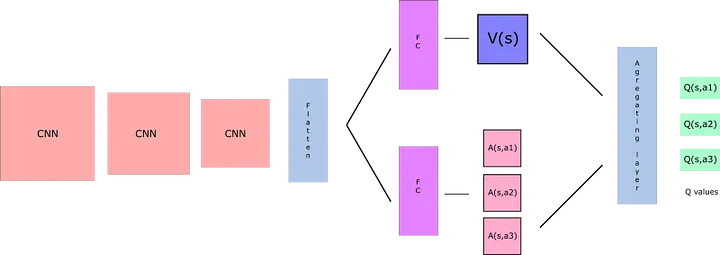


Image from https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751

The difference of Dueling DQN with respect to the baseline DQN is that we divide the network into two distinct streams: one for predicting the state's value and the other for predicting the action advantages based on the state. Following the two streams, the final module in the network merges the state-value and advantage results. 

In [23]:
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_size, 512),
            nn.ReLU()
        )
        # Value stream
        self.value_stream = nn.Linear(512, 1)
        
        # Advantage stream
        self.advantage_stream = nn.Linear(512, action_size)
    
    def forward(self, x):
        x = self.shared(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine the value and advantage streams to get the Q-values
        Q_values = value + (advantage - advantage.mean())
        return Q_values
    
# This network was executed before the function "run_dqn" was defined but it was moved here for the sake of readability

In [ ]:
best_hyperparameters = {'hidden_size': 512, 
                        'experience_replay_size': 10000, 
                        'eps_start': 1.0, 
                        'eps_decay': 0.999965, 
                        'eps_min': 0.02, 
                        'learning_rate': 1e-3, 
                        'gamma': 0.999, 
                        'step_size': 100, 
                        'sync_target_network': 500, 
                        'max_frames': 200000000, # we set it to a huge number with the hope of it early stopping 
                        'batch_size': 256, 
                        'trial_id': 'best'}

run_dqn(best_hyperparameters, "dueling_dqn", dueling_dqn=True)

In [4]:
best_results_folder = "./results_dueling_dqn/best_28-15-05/videos"
out_path = "./Metrics/DuelingDQN/best.gif"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
merge_gifs(best_results_folder, out_path)

#### Evolution of training for the best run
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Best Run (solved in 322 episodes | 79,418 frames)</p>
        <img src="Metrics/DuelingDQN/best.gif" alt="Total frames" width="1000">
    </div>
</div>

#### Final metrics for best run
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - Total Frames</p>
        <img src="Metrics/DuelingDQN/Dueling DQN - Total Frames.png" alt="Total frames" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - Average Score</p>
        <img src="Metrics/DuelingDQN/Dueling DQN - Average Score.png" alt="Average Score" width="700">
    </div>
</div>
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - Loss</p>
        <img src="Metrics/DuelingDQN/Dueling DQN - Loss.png" alt="Loss" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - LR</p>
        <img src="Metrics/DuelingDQN/Dueling DQN - LR.png" alt="Learning Rate" width="700">
    </div>
</div>


This right here composes the best run I executed over all the algorithms and hyperparameters. The final evaluation shown in the training video also showcases that this run ends up learning a really fast descent while still mantaining a smooth landing. From the training curves we can also see this smooth training as the avarage score is extrictly upwards. 

Best hyperparameters found: 

| Hyperparameter            | BEST              |
|---------------------------|--------------------|
| `hidden_size`             | 512                |
| `experience_replay_size`  | 10000              |
| `eps_start`               | 1.0                |
| `eps_decay`               | 0.999965           |
| `eps_min`                 | 0.02               |
| `learning_rate`           | 0.00075               |
| `gamma`                   | 0.999              |
| `step_size`               | 100                |
| `sync_target_network`     | 500                |


### Double DQN

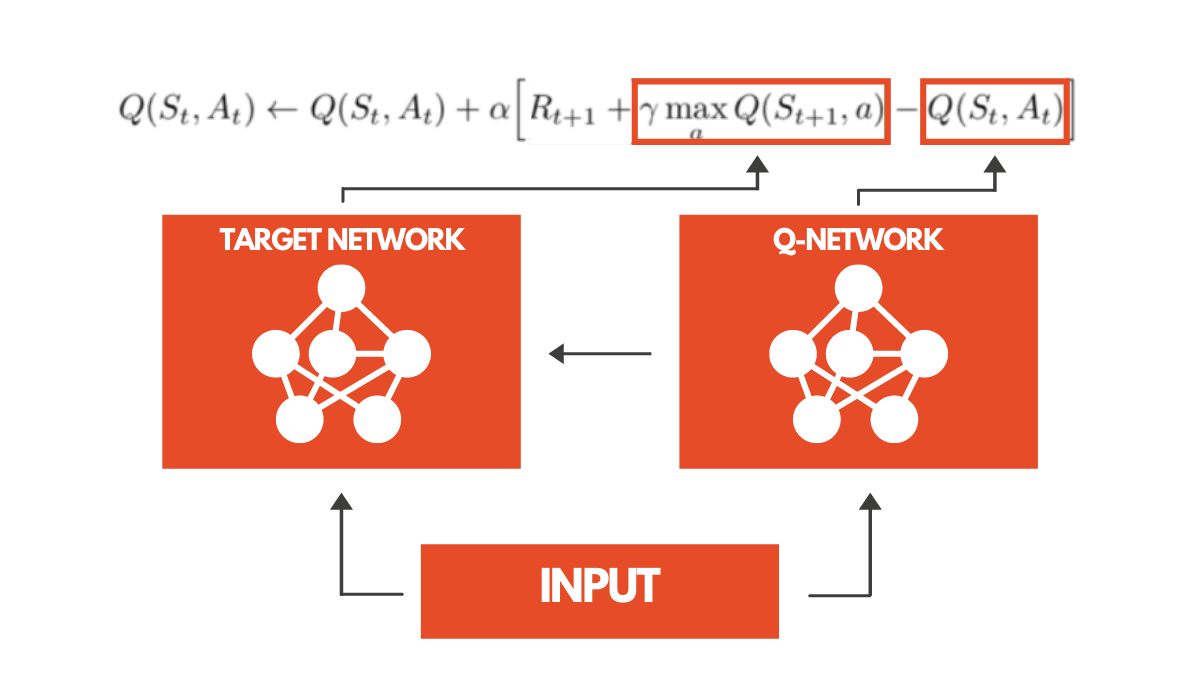

Image from https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/

Next, Double DQN adds the innovation of using two networks to separate the selection of the action and the evaluation of the action. This helps to reduce the overestimation of Q-values that can occur in DQN.


In [ ]:
best_hyperparameters = {'hidden_size': 512, 
                        'experience_replay_size': 10000, 
                        'eps_start': 1.0, 
                        'eps_decay': 0.999965, 
                        'eps_min': 0.02, 
                        'learning_rate': 75e-5, 
                        'gamma': 0.999, 
                        'step_size': 100, 
                        'sync_target_network': 500, 
                        'max_frames': 200000000, # we set it to a huge number with the hope of it early stopping 
                        'batch_size': 256, 
                        'trial_id': 'best'}

run_dqn(best_hyperparameters, "dueling_dqn", dueling_dqn=True)

In [5]:
best_results_folder = "./results_double_dqn/best_28-15-00/videos"
out_path = "./Metrics/DoubleDQN/best.gif"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
merge_gifs(best_results_folder, out_path)

#### Evolution of training for the best run
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Best Run (solved in 402 episodes | 127,875 frames)</p>
        <img src="Metrics/DoubleDQN/best.gif" alt="Total frames" width="1000">
    </div>
</div>

#### Final metrics for best run
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - Total Frames</p>
        <img src="Metrics/DoubleDQN/Double DQN - Total Frames.png" alt="Total frames" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - Average Score</p>
        <img src="Metrics/DoubleDQN/Double DQN - Average Score.png" alt="Average Score" width="700">
    </div>
</div>
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - Loss</p>
        <img src="Metrics/DoubleDQN/Double DQN - Loss.png" alt="Loss" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Dueling DQN - LR</p>
        <img src="Metrics/DoubleDQN/Double DQN - LR.png" alt="Learning Rate" width="700">
    </div>
</div>


Finally, this second extension of the DQN Baseline algorihm doesn't seem such to be such an advantage with respect to the baseline. It manages to learn in 402 episodes which is okay but not better than the baseline. Although Double DQN involves incorporating a separate target network to address the issue of overestimation of Q-values, this increased complexity may lead to decreased update aggressiveness by the agent, ultimately resulting in a slower convergence process. In games such as Lunar Lander, the extra stability from Double DQN may actually slow down the agent's learning of the best actions due to the need for fast and accurate decision-making. However, Baseline DQN, lacking the overestimation correction, has a tendency to make faster and more straightforward updates, potentially proving more efficient in dynamic, high-reward settings.

Best hyperparameters found: 

| Hyperparameter            | BEST              |
|---------------------------|--------------------|
| `hidden_size`             | 512                |
| `experience_replay_size`  | 10000              |
| `eps_start`               | 1.0                |
| `eps_decay`               | 0.999965           |
| `eps_min`                 | 0.02               |
| `learning_rate`           | 0.001               |
| `gamma`                   | 0.999              |
| `step_size`               | 100                |
| `sync_target_network`     | 500                |


### Summary of DQN methods

| Hyperparameter            | Baseline DQN | Dueling DQN | Double DQN |
|---------------------------|--------------|-------------|------------|
| `hidden_size`             | 512          | 512         | 512        |
| `experience_replay_size`  | 10000        | 10000       | 10000      |
| `eps_start`               | 1.0          | 1.0         | 1.0        |
| `eps_decay`               | 0.999965     | 0.999965    | 0.999965   |
| `eps_min`                 | 0.02         | 0.02        | 0.02       |
| `learning_rate`           | 0.001        | 0.00075     | 0.001      |
| `gamma`                   | 0.999        | 0.999       | 0.999      |
| `step_size`               | 100          | 100         | 100        |
| `sync_target_network`     | 500          | 500         | 500        |
| Converged in              | 360 episodes / 102,224 frames              |  322 episodes / 79,418 frames             | 402 episodes / 127,875 frames           |

To find the optimal hyperparameters for Dueling and Double DQN, I started with the best settings from the Baseline DQN and conducted several tests, carefully adjusting key parameters like the learning rate and epsilon decay. This iterative process ensured that each model was fine-tuned to its specific architecture while maintaining the core strengths of the original setup. The reason the hyperparameters for the baseline and its extensions remain so similar is that they all share the same foundational architecture and learning principles. Their main focus is on altering the process of calculating the value function (e.g., by distinguishing between value and advantage in Dueling DQN or decreasing overestimation bias in Double DQN) which ensures that most of the hyperparameters continue to be efficient without major adjustments. This likeness also helps to compare the results between models since any upgrades in capability are a result of the enhancements in architecture rather than variations in adjustment.

## Part 2. REINFORCE Agent

Like in DQN, we implement the functions to evaluate the model and run the training loop for the Double DQN algorithm. As well as the model architecture.

In [7]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def evaluate_reinforce(env, model, dir, epoch):
    # reset the environment
    state, _ = env.reset()
    rewards = []
    images = []

    # T=2000 max
    total_reward = 0
    for t in range(1000):
        # get predictions from the model and select the action according to probability distribution
        img = env.render()
        
        pred = model(torch.from_numpy(state).float().to(device))
        # action = np.random.choice(np.arange(len(pred)), p=np.array(pred.detach()))
        action = torch.multinomial(pred, 1).item()
        
        # get image to export the video
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)  # Create an ImageDraw object
        
        # Add step number and total reward to the image
        font = ImageFont.load_default()  # Load default font
        img_width, img_height = img_pil.size  # Get image dimensions
        
        # Step in the upper left corner
        draw.text((10, 10), f"Step: {t}", fill="white", font=font)
        
        # Write the number of training epochs in the upper middle
        epoch_text = f"Epoch: {epoch}"
        text_bbox = draw.textbbox((0, 0), epoch_text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        draw.text(((img_width - text_width) // 2, 10), epoch_text, fill="white", font=font)
        
        # Accumulated reward in the upper right corner
        reward_text = f"Reward: {total_reward:.2f}"
        text_bbox = draw.textbbox((0, 0), reward_text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        draw.text((img_width - text_width - 10, 10), reward_text, fill="white", font=font)

        images.append(img_pil)

        # execute action and get reward and new state
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        total_reward += reward

        if done:
            # print("Reward:", sum([r for r in rewards]))
            break

    # duration is the number of milliseconds between frames; this is 40 frames per second
    images[0].save(dir, save_all=True, append_images=images[1:], duration=60, loop=0)
    
    # close Env
    env.close()
    return total_reward

In [10]:
class Reinforce(nn.Module):
    def __init__(self, obs_size, n_actions, first_hidden_size, second_hidden_size):
        super(Reinforce, self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(obs_size, first_hidden_size, bias=True),
                    nn.Tanh(),
                    nn.Linear(first_hidden_size, second_hidden_size, bias=True),
                    nn.Tanh(),
                    nn.Linear(second_hidden_size, n_actions, bias=True),
                    nn.Softmax(dim=-1),
                    )
        
    def forward(self, x):
        out = self.net(x)
        return out

In [13]:
import torch
import wandb
import time
import os
import numpy as np

os.environ["WANDB_SILENT"] = "true"

def run_reinforce(hyperparams):
    """
    Runs the REINFORCE algorithm with given hyperparameters.
    
    Args:
        hyperparams (dict): A dictionary containing the hyperparameters.
            Expected keys: 
                - "learning_rate"
                - "step_size"
                - "lr_decay"
                - "gamma"
                - "max_trajectories"
    
    Returns:
        float: The average score over the last 100 trajectories.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = make_env(MAX_STEPS_PER_EPISODE=1000)

    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    # Extract hyperparameters
    learning_rate = hyperparams["learning_rate"]
    step_size = hyperparams["step_size"]
    lr_decay = hyperparams["lr_decay"]
    gamma = hyperparams["gamma"]
    max_trajectories = hyperparams["max_trajectories"]
    first_hidden_size = hyperparams["first_hidden_size"]
    second_hidden_size = hyperparams["second_hidden_size"]
    trial_id = hyperparams["trial_id"]

    time_str = time.strftime("%d-%H-%M")
    id_run = f"{trial_id}_{time_str}"
    results_dir = f"./results_reinforce/{id_run}"
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(f"{results_dir}/checkpoints/", exist_ok=True)
    os.makedirs(f"{results_dir}/videos/", exist_ok=True)

    # Create a log file
    log_file = open(f"{results_dir}/training_log.txt", "w")

    best_score = -10000

    with wandb.init(project="RL-Activities", name=f"PRA2_REINFORCE_{id_run}", config=hyperparams):
        score = []
        model = Reinforce(obs_size, n_actions, first_hidden_size, second_hidden_size).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=lr_decay)

        for trajectory in range(max_trajectories):
            current_state, _ = env.reset()
            transitions = []

            with torch.no_grad():
                for t in range(env.spec.max_episode_steps):
                    actions_prob = model(torch.from_numpy(current_state).float().to(device))
                    # print(actions_prob.shape)
                    action = torch.multinomial(actions_prob, 1).item()

                    previous_state = current_state
                    current_state, reward, terminated, truncated, info = env.step(action)

                    transitions.append((previous_state, action, reward))
                    if terminated or truncated:
                        break

            # Calculate total reward for the trajectory
            score.append(sum([r for (s, a, r) in transitions]))

            # Prepare data for policy gradient update
            state_batch = torch.tensor(np.array([s for (s, a, r) in transitions]), dtype=torch.float32)
            reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,))
            action_batch = torch.LongTensor([a for (s, a, r) in transitions]).to(device)
            log_prob = torch.log(model(state_batch.float().to(device)))
            prob_batch = log_prob.gather(1, action_batch.unsqueeze(-1)).squeeze(-1)

            discounted_rewards = []
            R = 0
            for r in reward_batch:
                R = r + gamma * R
                discounted_rewards.insert(0, R)
            discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32).to(device)

            # Normalize discounted rewards
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

            loss = torch.sum(-prob_batch.to(device) * discounted_rewards.to(device))

            wandb.log({"loss": loss.item()}, step=trajectory)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Checkpoint and evaluation logic
            if trajectory % 50 == 0 and trajectory > 0:
                avg_last_100 = np.mean(score[-100:-1])
                log_file.write(f'Trajectory {trajectory}\tAverage Score: {avg_last_100:.2f}\n')
                log_file.flush()
                wandb.log({"average_score": avg_last_100, "lr": optimizer.param_groups[0]['lr'], 
                           'average_whole_training': np.mean(score)}, step=trajectory)

                if avg_last_100 > env.spec.reward_threshold:
                    log_file.write(f"Environment solved in {trajectory} steps\n")
                    torch.save(model.state_dict(), f"{results_dir}/checkpoints/last.pth")
                    
                    eval_reward = evaluate_reinforce(env, model, f"{results_dir}/videos/000last.gif", epoch=trajectory)
                    log_file.write(f"Eval reward: {eval_reward}\n")
                    break

                if avg_last_100 > best_score+10:
                    best_score = avg_last_100
                    torch.save(model.state_dict(), f"{results_dir}/checkpoints/best.pth")

            if trajectory % 100 == 0 and trajectory > 0:
                log_file.write("Evaluating...\n")
                eval_reward = evaluate_reinforce(env, model, f"{results_dir}/videos/{trajectory:05d}.gif", epoch=trajectory)
                log_file.write(f"Eval reward: {eval_reward}\n")
                wandb.log({"eval_reward": eval_reward}, step=trajectory)

        wandb.summary["average_score"] = np.mean(score[-100:])
        return np.mean(score[-100:])


Like in DQN to choose the best hyperparameters I used Optuna. Again, I define the search space for each hyperparameter and the objective function to minimize the loss. Later I will run the best hyperparameters found in a full training session.
    

In [ ]:
import optuna
from IPython.display import clear_output

def objective(trial):
    # Define hyperparameter search space
    hyperparams = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
        "step_size": trial.suggest_int("step_size", 1, 200),
        "lr_decay": trial.suggest_float("lr_decay", 0.1, 0.99),
        "gamma": trial.suggest_float("gamma", 0.1, 0.99),
        "first_hidden_size": trial.suggest_int("first_hidden_size", 8, 512),
        "second_hidden_size": trial.suggest_int("second_hidden_size", 16, 512),
        "max_trajectories": 2000,  # You can also make this a hyperparameter
        "trial_id": trial.number
    }
    return run_reinforce(hyperparams)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

clear_output()
print("Best hyperparameters: ", study.best_params)
print("Best value: ", study.best_value)


#### Final training with best hyperparameters

In [ ]:
hyperparams = {
    "learning_rate": 5e-3,
    "step_size": 100,
    "lr_decay": 0.97,
    "gamma": 0.99,
    "first_hidden_size": 16,
    "second_hidden_size": 32,
    "max_trajectories": 10000, 
    "trial_id": "best"
}
    
reward = run_reinforce(hyperparams, None)

In [6]:
best_results_folder = "./results_reinforce2/best_28-12-36/videos"
out_path = "./Metrics/Reinforce/best.gif"
merge_gifs(best_results_folder, out_path)

#### Evolution of training for the best run
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Best Run (solved in 800 episodes)</p>
        <img src="Metrics/Reinforce/best.gif" alt="Total frames" width="1000">
    </div>
</div>

#### Final metrics for converging runs
<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="margin: 5px; text-align: center;">
        <p>Baseline DQN - Average Score</p>
        <img src="Metrics/Reinforce/REINFORCE - Average Score.png" alt="Average Score" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Baseline DQN - Loss</p>
        <img src="Metrics/Reinforce/REINFORCE - Loss.png" alt="Loss" width="700">
    </div>
    <div style="margin: 5px; text-align: center;">
        <p>Baseline DQN - Learning Rate</p>
        <img src="Metrics/Reinforce/REINFORCE - LR.png" alt="Learning Rate" width="700">
    </div>
</div>


Plots shown: 
- Average Score: mean reward obtained in the last 100 episodes. 

- Loss: computed loss per each episode computed.

- Learning rate: learning rate at each episode. Declining due to the scheduler. 

This run is surprisingly smooth, like in DQN, the results of runs using the same hyperparameters vary. In this specific case, the run accomplishes to solve the environment in 800 episodes. From the training curve of the loss, we can see that the model learns to predict the rewords pretty good. Getting to a minim of around -100. In this specific set of parameters, the learning rate decreases with gamma 0.99 every 100 steps (episodes). It is also interesting to see that the network is really small, with just 3 linears, one that goes from 8 (state size) to 16 and another one that goes from 16, 32  and lastly another one that goes from 32 to 4 (num actions).

If we compare the performance to DQN we can see that Reinforce takes more time to solve the environment, which seems surprising to me because i would have guess the oposite since Reinforce has a more direct effect in the actions to choosen instead of modeling a Q-value function that then is used to choose the actions. 

Best hyperparameters found: 

| Hyperparameter            | BEST              |
|---------------------------|--------------------|
| `learning_rate`           | 0.005               |
| `step_size`               | 100                |
| `gamma`                   | 0.99              |
| `first_hidden_size`  | 16              |
| `second_hidden_size`               | 32                |


### Final conclusions

In the following table we can see how much did each model / variation take to solve the environment. The winer in this particular environment is Dueling DQN followed really close by the basline DQN and the Double DQN. Finally the Reinforce algorithm is the worse performing one and it takes around x2 the episodes DQN needs to learn. 

| Model            | Episodes needed to converge |
|------------------|-----------------------------|
| Baseline DQN     | 360                         |
| Dueling DQN      | 322                         |
| Double DQN       | 403                         |
| Policy gradient  | 800                         |

**Why Reinforce is better than DQN in this case?** 

One of the key reasons can be that DQNs don't need to wait till the end of the episode for training the agent while REINFORCE gets the final reward after episode completion. This means that DQNs can update the Q-values after every step using the immediate reward and future estimates, leading to faster and more stable learning. In contrast, Reinforce relies on episode-wide returns, which makes the updates noisier and slower, especially in environments like Lunar Lander where episodes can be long and the rewards sparse. 

##### Proof of hyperparameter search

Since I don't explicitly show that I did all the runs for the hyperparameter search I will attach some screnshoots of the runs ran in wandb. They are grouped by the algorithm used. The group "null" contains runs from Reinforce and Baseline - DQN.

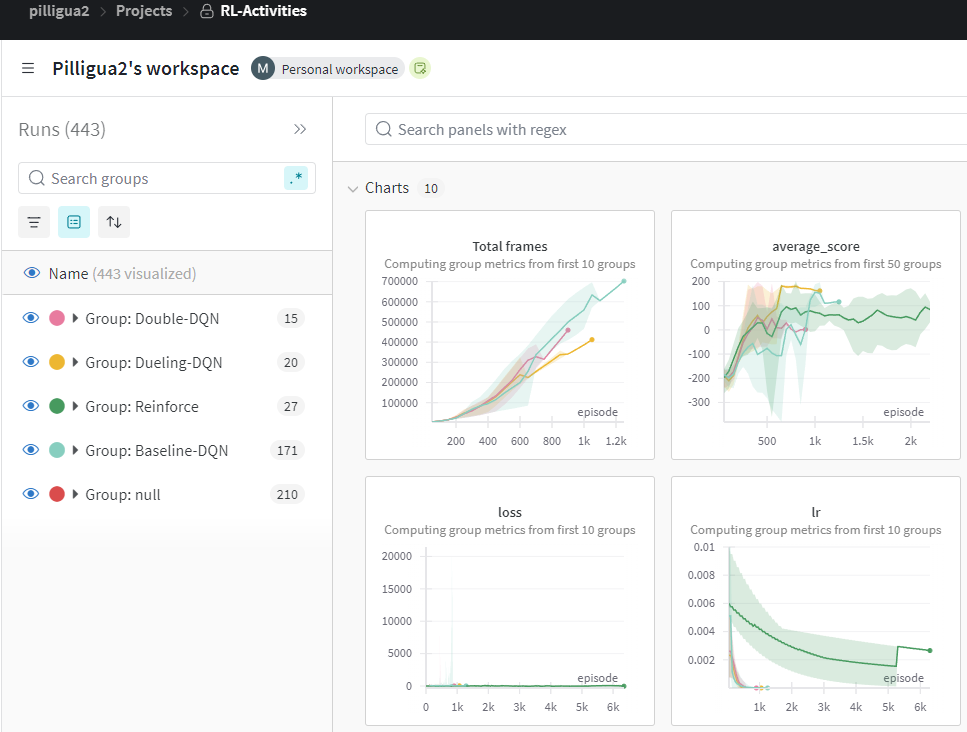